# Topic Modeling

- Text Preprocessing
- LDA

In [42]:
import numpy as np
import pandas as pd
import nltk, re, string, contractions
from nltk.tokenize import sent_tokenize, word_tokenize
import email
from nltk.corpus import stopwords
from nltk.util import bigrams, trigrams
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_json(r'F:\Muthu_2023\Personal\NextStep\NLP\NLP\Dataset\Musical_Instruments_5.json', lines = True)

In [4]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewerID      10261 non-null  object
 1   asin            10261 non-null  object
 2   reviewerName    10234 non-null  object
 3   helpful         10261 non-null  object
 4   reviewText      10261 non-null  object
 5   overall         10261 non-null  int64 
 6   summary         10261 non-null  object
 7   unixReviewTime  10261 non-null  int64 
 8   reviewTime      10261 non-null  object
dtypes: int64(2), object(7)
memory usage: 721.6+ KB


# EDA

In [6]:
def temp_process_text(text):
    return re.sub("[^a-zA-Z0-9 ]", "", text)

In [7]:
review_processed = df['reviewText'].apply(temp_process_text)

<Axes: ylabel='Frequency'>

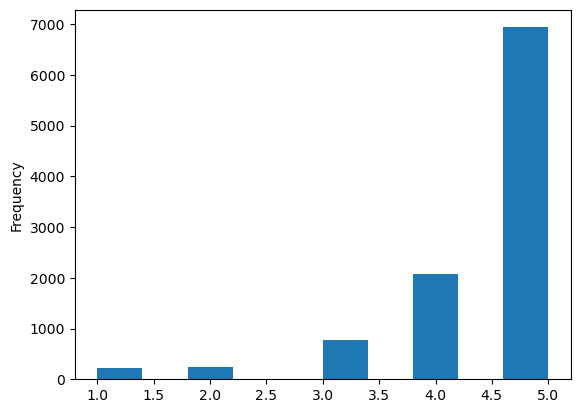

In [29]:
df['overall'].plot(kind='hist')

`Most of ratings of the musical instruments are high`

<Axes: xlabel='reviewText', ylabel='Count'>

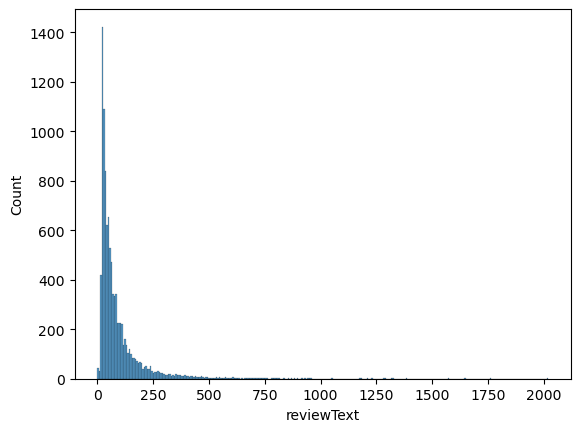

In [28]:
sns.histplot(review_processed.str.split().apply(len))

`Majority of the reviews are under 100 words`

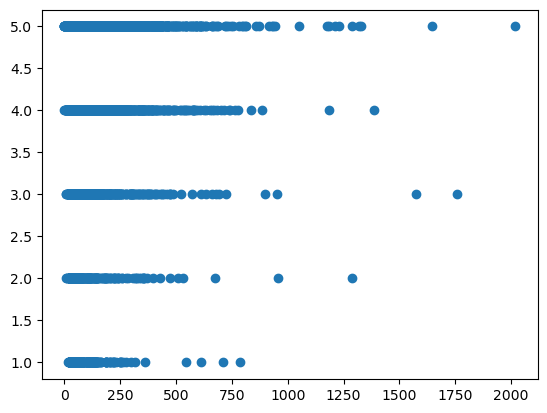

In [15]:
plt.scatter(review_processed.str.split().apply(len), y = df['overall'])

<Axes: xlabel='reviewText', ylabel='overall'>

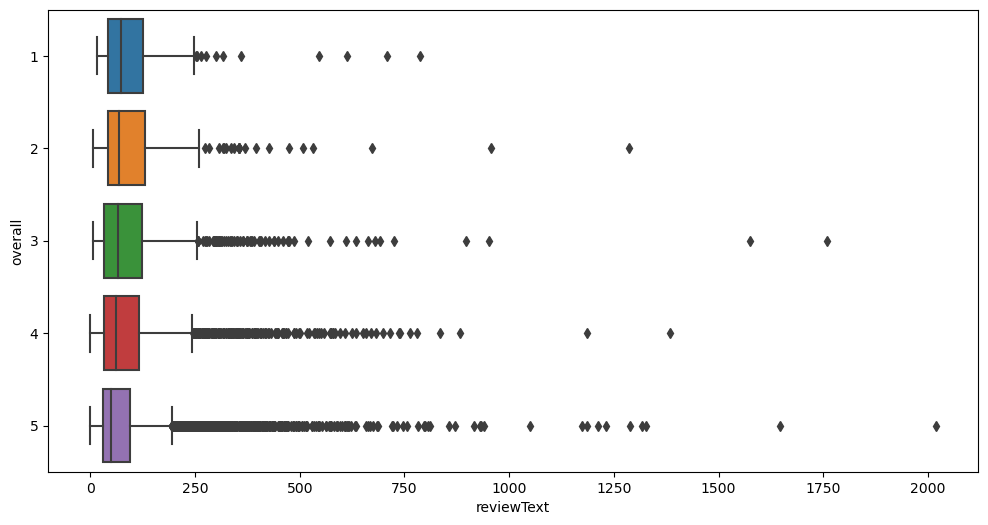

In [21]:
plt.figure(figsize=(12,6))
sns.boxplot(x = review_processed.str.split().apply(len), y = df['overall'], orient = 'horizontal')

`Average Length of review increases with rating`

# Text Preprocessing

- **`Apply contractions`**
- **`Remove Stopwords and all non alpha numeric characters`**
- **`Strip the and lower case the text`**

In [39]:
def text_preprocess(text):
    sw = stopwords.words('english')
    words = word_tokenize(re.sub("[^a-zA-Z0-9 ]", "", contractions.fix(text).lower()))
    word_list = []
    for word in words:
        if word.isalpha() and len(word) < 20 and word not in sw:
            word_list.append(word)
    return word_list

In [40]:
df['text_processed'] = df['reviewText'].apply(text_preprocess)

In [41]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,text_processed
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014","[much, write, exactly, supposed, filters, pop,..."
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013","[product, exactly, quite, affordablei, realize..."
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013","[primary, job, device, block, breath, would, o..."
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014","[nice, windscreen, protects, mxl, mic, prevent..."
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014","[pop, filter, great, looks, performs, like, st..."


# Word Cloud

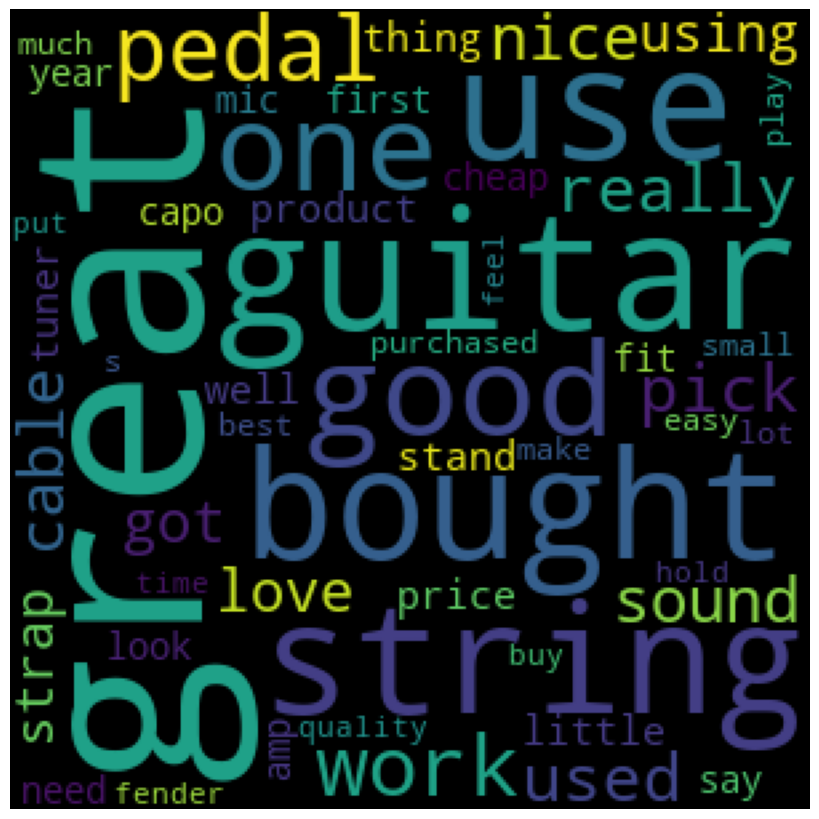

In [48]:
wc = WordCloud(width = 300, height = 300,
                background_color ='black',
                min_font_size = 10).generate(df['text_processed'].to_string())
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

# Noun based Topic Modeling

In [55]:
def extract_nouns(text):
    pos = nltk.pos_tag(text)
    return [word[0] for word in pos if word[1] in ['NN', 'NNS', 'NNP']]

In [59]:
df['Nouns'] = df['text_processed'].apply(extract_nouns)

In [60]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,text_processed,Nouns
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014","[much, write, exactly, supposed, filters, pop,...","[write, filters, recordings, prices, pop, filt..."
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013","[product, exactly, quite, affordablei, realize...","[product, expectedas, bonus, screens, hint, sm..."
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013","[primary, job, device, block, breath, would, o...","[job, device, block, breath, voice, pass, redu..."
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014","[nice, windscreen, protects, mxl, mic, prevent...","[protects, prevents, thing, gooseneck, hold, p..."
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014","[pop, filter, great, looks, performs, like, st...","[pop, filter, performs, studio, filter, vocals..."
